In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
# Load the dataset with Dask
ds = xr.open_dataset('era5.nc', chunks={'time': 10})
ds

<xarray.Dataset> Size: 36MB
Dimensions:                  (time: 1468, longitude: 64, latitude: 32)
Coordinates:
  * time                     (time) datetime64[ns] 12kB 2020-01-01 ... 2021-0...
  * longitude                (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * latitude                 (latitude) float64 256B -90.0 -84.19 ... 84.19 90.0
Data variables:
    10m_wind_speed           (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>
    2m_temperature           (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>
    total_precipitation_6hr  (time, longitude, latitude) float32 12MB dask.array<chunksize=(10, 64, 32), meta=np.ndarray>

In [65]:
ds_array = ds.to_array().transpose('time', 'longitude', 'latitude', 'variable')
T, LON, LAT, F = ds_array.shape

X = ds_array[:-1].stack(space=['longitude', 'latitude', 'variable'])
y = ds_array[1:].stack(space=['longitude', 'latitude', 'variable'])

X

# # Convert Dask arrays to NumPy arrays for ML training (if needed)
# X = X.compute()
# y = y.compute()

<xarray.DataArray (time: 1467, space: 6144)> Size: 36MB
dask.array<reshape, shape=(1467, 6144), dtype=float32, chunksize=(10, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 12kB 2020-01-01 ... 2021-01-01T12:00:00
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [70]:
from dask_ml.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X.shape, X_train.shape, X_test.shape
X_train

<xarray.DataArray (time: 1173, space: 6144)> Size: 29MB
dask.array<getitem, shape=(1173, 6144), dtype=float32, chunksize=(2, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 9kB 2020-06-12T12:00:00 ... 2020-10-08T1...
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [90]:
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# Since this is regression, we must also scale the y
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test)

X_train_scaled

<xarray.DataArray (time: 1173, space: 6144)> Size: 29MB
dask.array<truediv, shape=(1173, 6144), dtype=float32, chunksize=(2, 2112), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 9kB 2020-06-12T12:00:00 ... 2020-10-08T1...
  * space      (space) object 49kB MultiIndex
  * longitude  (space) float64 49kB 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 49kB -90.0 -90.0 -90.0 -84.19 ... 90.0 90.0 90.0
  * variable   (space) object 49kB '10m_wind_speed' ... 'total_precipitation_...

In [91]:
np.var(X_train_scaled, axis=0).values

array([1.0000002 , 1.000001  , 1.0000006 , ..., 0.99999946, 1.0000002 ,
       1.        ], dtype=float32)

# Time to create some graphs!!

In [105]:
X_train_scaled_xr = X_train_scaled.unstack('space')
y_train_scaled_xr = y_train_scaled.unstack('space')
X_test_scaled_xr = X_test_scaled.unstack('space')
y_test_scaled_xr = y_test_scaled.unstack('space')

X_train_scaled_xr.shape

(1173, 64, 32, 3)

In [144]:
ds.latitude.values

array([-90.        , -84.19354839, -78.38709677, -72.58064516,
       -66.77419355, -60.96774194, -55.16129032, -49.35483871,
       -43.5483871 , -37.74193548, -31.93548387, -26.12903226,
       -20.32258065, -14.51612903,  -8.70967742,  -2.90322581,
         2.90322581,   8.70967742,  14.51612903,  20.32258065,
        26.12903226,  31.93548387,  37.74193548,  43.5483871 ,
        49.35483871,  55.16129032,  60.96774194,  66.77419355,
        72.58064516,  78.38709677,  84.19354839,  90.        ])

TODO: Create a graph for _each_ time step and each of the data subsets.

In [147]:
longitude = ds.longitude.values
latitude = ds.latitude.values

# Initialize a graph
G = nx.Graph()

# Add nodes
for lon in longitude:
    for lat in latitude:
        feature_values = X_test_scaled_xr.isel(time=0).sel(longitude=lon, latitude=lat).values  # Extract features for the first time step
        G.add_node((lon, lat), features=feature_values)

# Add edges (connect each node to its direct neighbors)
for x, lon in enumerate(longitude):
    for y, lat in enumerate(latitude):
        G.add_edge((lon, lat), (longitude[(x - 1) % len(longitude)], lat))  # Connect to the west
        G.add_edge((lon, lat), (lon, latitude[(x + 1)  % len(latitude)]))  # Connect to the north

        # G.add_edge((lon, lat), (longitude[(x + 1) % len(longitude)], lat))  # Connect to the east
        # G.add_edge((lon, lat), (lon, latitude[(x - 1) % len(latitude)]))  # Connect to the south
        

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 2048 nodes and 4096 edges


In [148]:
# Access features of a specific node
node_id = (354.375, -90)
node_features = G.nodes[node_id]['features']
print(f"Features of node {node_id}: {node_features}")

Features of node (354.375, -90): [1.0477197  0.23162138 0.8927893 ]


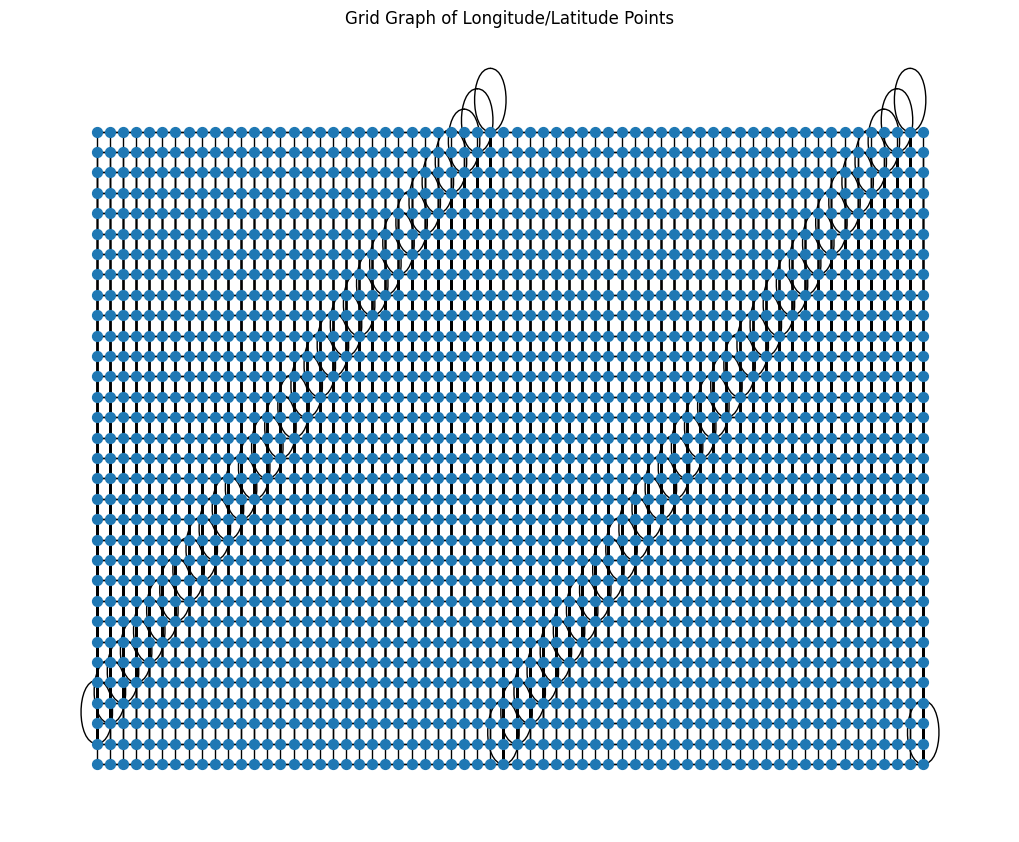

In [151]:
# Generate positions for the nodes (optional, for better visualization)
pos = {(lon, lat): (lon, lat) for lon in longitude for lat in latitude}

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=False, node_size=50)
plt.title("Grid Graph of Longitude/Latitude Points")
plt.show()

TODO: Given a list of networkx graphs, make a data loader